In [1]:
%reload_ext tensorboard
# %tensorboard --logdir=logs/validation --host localhost   --port 6021
%tensorboard --logdir=logs/train --host localhost   --port 6021

# %tensorboard --logdir=logs --host localhost   --port 6022
# %tensorboard --logdir=logs --host localhost   --port 6022

In [6]:
import glob
import os
models_dir = "models_nfeats_60_fsc_1.1/"
latest_weight = max(glob.glob(os.path.join(models_dir, 'weights_epoch_*.h5')), key=os.path.getctime, default=None)
epoch_number = int(latest_weight.split('_')[-1].split('.')[0])
print(epoch_number)

2000


In [69]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from scipy.stats import ttest_ind
# import glob
# import os

# results_dir = 'results/'
# csv_files = glob.glob(os.path.join(results_dir, '*.csv'))
# data_frames = []

# for file in csv_files:
#     model_name = os.path.basename(file).replace('result_', '').replace('.csv', '')
#     df = pd.read_csv(file, header=None, names=['Step', 'Dice Score'])
#     if model_name == '1.1':
#         model_name = "Small Unet"
#     elif model_name == '1.75':
#         model_name = "Big Unet"
#     elif model_name == '32':
#         model_name = "Subnet 32"
#     elif model_name == '64':
#         model_name = "Subnet 64"
#     df['Model'] = model_name
#     data_frames.append(df)

# all_results = pd.concat(data_frames, ignore_index=True)

# plt.figure(figsize=(10, 6))

# # Define the order of the models
# model_order = ["Small Unet", "Subnet 32", "Big Unet", "Subnet 64"]

# # Define custom colors for each model
# colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]

# # Using custom color palette
# boxplot = sns.boxplot(x='Model', y='Dice Score', data=all_results, order=model_order, palette=colors)

# plt.title('Dice Scores for Different Models')
# plt.xlabel('Model')
# plt.ylabel('Dice Score')

# # Extract data for Small Unet and Subnet 32
# small_unet_data = all_results[all_results['Model'] == "Small Unet"]['Dice Score']
# subnet_32_data = all_results[all_results['Model'] == "Subnet 32"]['Dice Score']

# # Extract data for Big Unet and Subnet 64
# big_unet_data = all_results[all_results['Model'] == "Big Unet"]['Dice Score']
# subnet_64_data = all_results[all_results['Model'] == "Subnet 64"]['Dice Score']

# # Perform t-test between Small Unet and Subnet 32
# t_statistic_1, p_value_1 = ttest_ind(small_unet_data, subnet_32_data)

# # Perform t-test between Big Unet and Subnet 64
# t_statistic_2, p_value_2 = ttest_ind(big_unet_data, subnet_64_data)

# print("T-test results between Small Unet and Subnet 32:")
# print("T-statistic:", t_statistic_1)
# print("P-value:", p_value_1)

# print("\nT-test results between Big Unet and Subnet 64:")
# print("T-statistic:", t_statistic_2)
# print("P-value:", p_value_2)

# # Annotate the plot with a star for significance
# if p_value_1 < 0.05:  # Set your significance level here
#     plt.text(1, min(subnet_32_data) + 0.095, '*', ha='center', va='center', fontsize=20)

# if p_value_2 < 0.05:  # Set your significance level here
#     plt.text(3, min(subnet_64_data) + 0.095, '*', ha='center', va='center', fontsize=20)

# plt.ylim(bottom=0.5)  # Ensure the annotation is within the plot's y-axis limits
# plt.show()


1.75
64
1.1
32


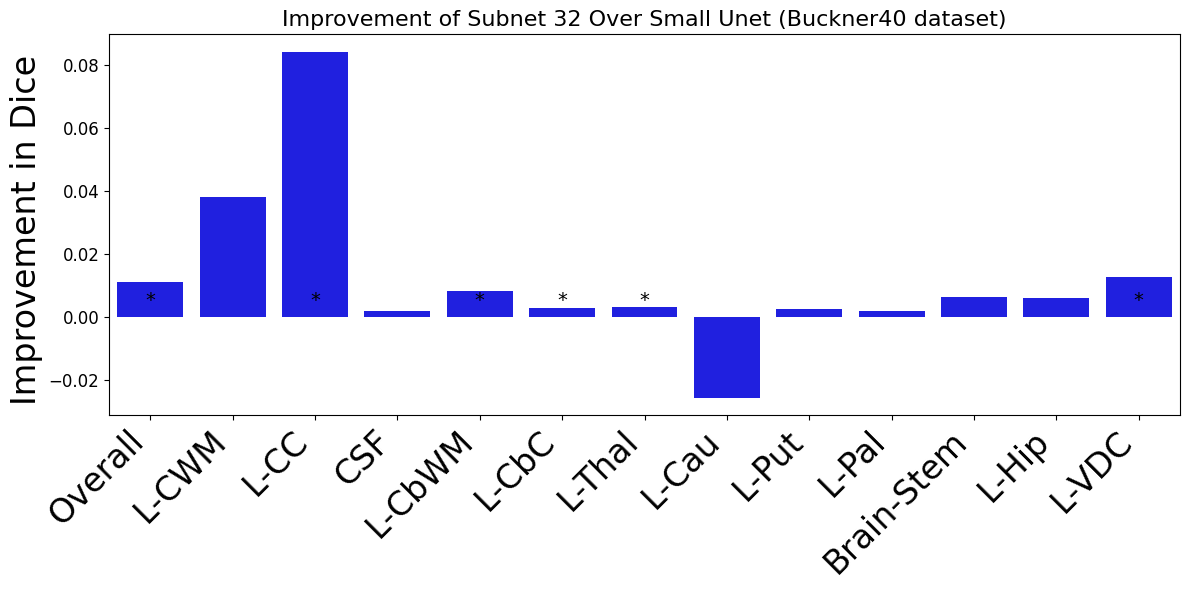

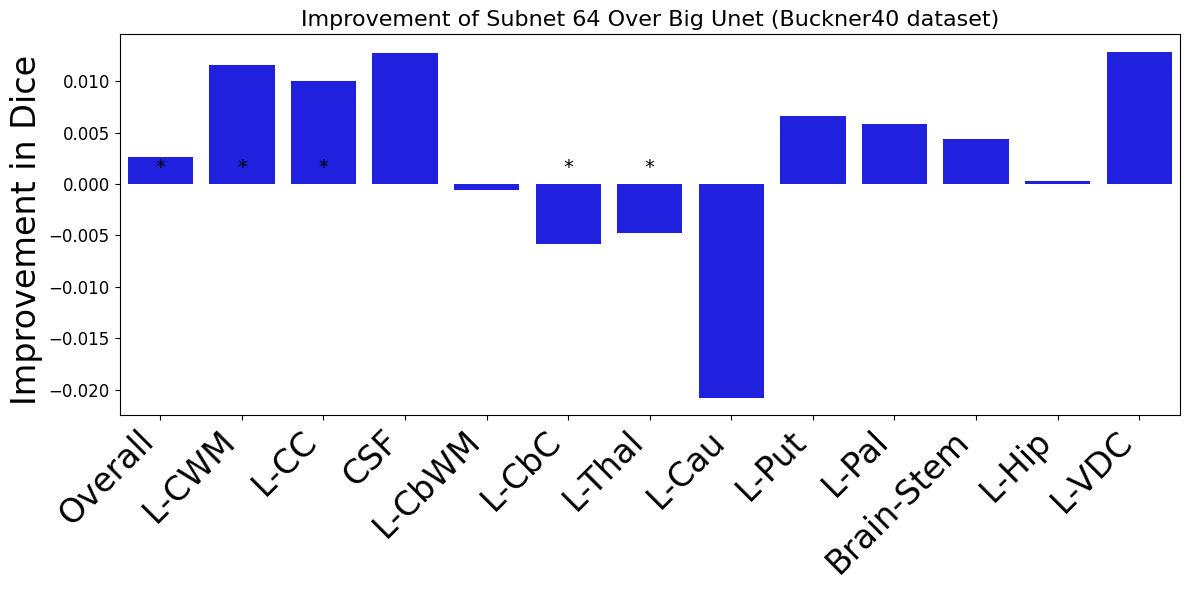

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from scipy import stats

# Define the dataset
dataset = "buckner40"
# dataset = "fbirn"
# dataset = "oasis"

label_ids = {
    "Unknown": 0,
    "Left-Cerebral-White-Matter": 1,
    "Left-Cerebral-Cortex": 2,
    "CSF": 3,
    "Left-Cerebellum-White-Matter": 4,
    "Left-Cerebellum-Cortex": 5,
    "Left-Thalamus": 6,
    "Left-Caudate": 7,
    "Left-Putamen": 8,
    "Left-Pallidum": 9,
    "Brain-Stem": 10,
    "Left-Hippocampus": 11,
    "Left-VentralDC": 15
}

measure = "dice"
results_dir = 'results/'
csv_files = glob.glob(os.path.join(results_dir, 'result_'+dataset+'*'+measure+'*.csv'))
data_frames = []

for file in csv_files:
    model_name = os.path.basename(file).replace('result_'+dataset+'_', '').replace('.csv', '').replace(measure, '').replace('_','')
    print(model_name)
    df = pd.read_csv(file)
    df['Model'] = model_name
    data_frames.append(df)

all_results = pd.concat(data_frames, ignore_index=True)

# Adjust model names for readability
model_name_mapping = {
    '1.1': 'Small Unet',
    '1.75': 'Big Unet',
    '32': 'Subnet 32',
    '64': 'Subnet 64'
}
all_results['Model'] = all_results['Model'].map(model_name_mapping)

# Transform data to long format for plotting, excluding "Unknown"
columns_to_exclude = ["Unknown"]
included_labels = [label for label in all_results.columns if label not in columns_to_exclude and label not in ['Step', 'Model']]
long_format = pd.melt(all_results, id_vars=['Step', 'Model'], value_vars=included_labels, var_name='Label', value_name='Dice Score')

# Customize labels
label_mapping = {}
long_format['Label'] = long_format['Label'].map(label_mapping).fillna(long_format['Label'])

# Compute mean and std for each structure and model combination
mean_std_results = long_format.groupby(['Label', 'Model'])['Dice Score'].agg(['mean', 'std']).reset_index()
mean_std_results.columns = ['Structure', 'Model', 'Mean', 'Std']

# Compute improvement of 'Subnet 32' over 'Small Unet'
improvement_df_32 = mean_std_results.pivot(index='Structure', columns='Model', values='Mean').reset_index()
improvement_df_32['Improvement (Subnet 32 - Small Unet)'] = improvement_df_32['Subnet 32'] - improvement_df_32['Small Unet']

# Compute improvement of 'Subnet 64' over 'Big Unet'
improvement_df_64 = mean_std_results.pivot(index='Structure', columns='Model', values='Mean').reset_index()
improvement_df_64['Improvement (Subnet 64 - Big Unet)'] = improvement_df_64['Subnet 64'] - improvement_df_64['Big Unet']

# Perform t-tests
def perform_ttest(data, model1, model2, structures):
    results = []
    for structure in structures:
        subset = data[data['Label'] == structure]
        scores1 = subset[subset['Model'] == model1]['Dice Score']
        scores2 = subset[subset['Model'] == model2]['Dice Score']
        if len(scores1) > 1 and len(scores2) > 1:  # Ensure there are enough samples for t-test
            t_stat, p_value = stats.ttest_ind(scores1, scores2, equal_var=False)
        else:
            p_value = float('nan')
        results.append((structure, p_value))
    return pd.DataFrame(results, columns=['Structure', 'p-value'])

# List of structures
structures = [
    'Overall',
    'Left-Cerebral-White-Matter',
    'Left-Cerebral-Cortex',
    'CSF',
    'Left-Cerebellum-White-Matter',
    'Left-Cerebellum-Cortex',
    'Left-Thalamus',
    'Left-Caudate',
    'Left-Putamen',
    'Left-Pallidum',
    'Brain-Stem',
    'Left-Hippocampus',
    'Left-VentralDC'
]

# Perform t-tests for both comparisons
ttest_results_32 = perform_ttest(long_format, 'Small Unet', 'Subnet 32', structures)
ttest_results_64 = perform_ttest(long_format, 'Big Unet', 'Subnet 64', structures)

# Annotate significance
def annotate_significance(ax, df, ttest_results, model1, model2, significance_level=0.05):
    for index, row in df.iterrows():
        p_value = ttest_results[ttest_results['Structure'] == row['Structure']]['p-value'].values
        if p_value and p_value[0] < significance_level:
            height = row[f'Improvement ({model2} - {model1})']
            ax.annotate('*', 
                        (index, 0/30.004),  # Position above the bar
                        ha='center', va='bottom', 
                        fontsize=14, color='black', 
                        xytext=(0, 5),  # Adjust vertical offset
                        textcoords='offset points')

# Define the custom order
custom_order = structures

# Ensure 'Overall' is in the DataFrame for both improvements
for df in [improvement_df_32, improvement_df_64]:
    if 'Overall' not in df['Structure'].values:
        # Create a row for 'Overall' if not present
        overall_row = df[['Structure', f'Improvement ({model2} - {model1})']].copy()
        overall_row['Structure'] = 'Overall'
        overall_row[f'Improvement ({model2} - {model1})'] = df[custom_order].mean(axis=1).values
        df = pd.concat([df, overall_row], ignore_index=True)
    df['Structure'] = pd.Categorical(df['Structure'], categories=custom_order, ordered=True)
    df = df.sort_values('Structure')

abbreviation_mapping = {
    'Overall': 'Overall',
    'Left-Cerebral-White-Matter': 'L-CWM',
    'Left-Cerebral-Cortex': 'L-CC',
    'CSF': 'CSF',
    'Left-Cerebellum-White-Matter': 'L-CbWM',
    'Left-Cerebellum-Cortex': 'L-CbC',
    'Left-Thalamus': 'L-Thal',
    'Left-Caudate': 'L-Cau',
    'Left-Putamen': 'L-Put',
    'Left-Pallidum': 'L-Pal',
    'Brain-Stem': 'Brain-Stem',
    'Left-Hippocampus': 'L-Hip',
    'Left-VentralDC': 'L-VDC'
}

# Abbreviate the structure names for plotting
improvement_df_32['Abbreviated Structure'] = improvement_df_32['Structure'].map(abbreviation_mapping)
improvement_df_64['Abbreviated Structure'] = improvement_df_64['Structure'].map(abbreviation_mapping)

# Plot improvements for Subnet 32 over Small Unet with abbreviated x-axis labels
plt.figure(figsize=(12, 6))
ax1 = sns.barplot(x='Abbreviated Structure', y='Improvement (Subnet 32 - Small Unet)', data=improvement_df_32, order=[abbreviation_mapping[struct] for struct in custom_order], color='blue')
plt.title(f'Improvement of Subnet 32 Over Small Unet ({dataset.capitalize()} dataset)', fontsize=16)
plt.xlabel('', fontsize=24)
plt.ylabel('Improvement in Dice ', fontsize=24)
plt.xticks(rotation=45, ha='right', fontsize=24)
plt.yticks(fontsize=12)
plt.tight_layout()
annotate_significance(ax1, improvement_df_32, ttest_results_32, 'Small Unet', 'Subnet 32')
plt.savefig(f'figs/{dataset}_improvement_subnet32.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot improvements for Subnet 64 over Big Unet with abbreviated x-axis labels
plt.figure(figsize=(12, 6))
ax2 = sns.barplot(x='Abbreviated Structure', y='Improvement (Subnet 64 - Big Unet)', data=improvement_df_64, order=[abbreviation_mapping[struct] for struct in custom_order], color='blue')
plt.title(f'Improvement of Subnet 64 Over Big Unet ({dataset.capitalize()} dataset)', fontsize=16)
plt.xlabel('', fontsize=24)
plt.ylabel('Improvement in Dice ', fontsize=24)
plt.xticks(rotation=45, ha='right', fontsize=24)
plt.yticks(fontsize=12)
plt.tight_layout()
annotate_significance(ax2, improvement_df_64, ttest_results_64, 'Big Unet', 'Subnet 64')
plt.savefig(f'figs/{dataset}_improvement_subnet64.png', dpi=300, bbox_inches='tight')
plt.show()

In [30]:
included_labels

['Overall',
 'Left-Cerebral-White-Matter',
 'Left-Cerebral-Cortex',
 'CSF',
 'Left-Cerebellum-White-Matter',
 'Left-Cerebellum-Cortex',
 'Left-Thalamus',
 'Left-Caudate',
 'Left-Putamen',
 'Left-Pallidum',
 'Brain-Stem',
 'Left-Hippocampus',
 'Left-VentralDC']

32
64
1.75
1.1


/scratch/5164282/ipykernel_41499/1062666873.py:100: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(wrapped_labels, rotation=40, ha='center', fontsize=18)


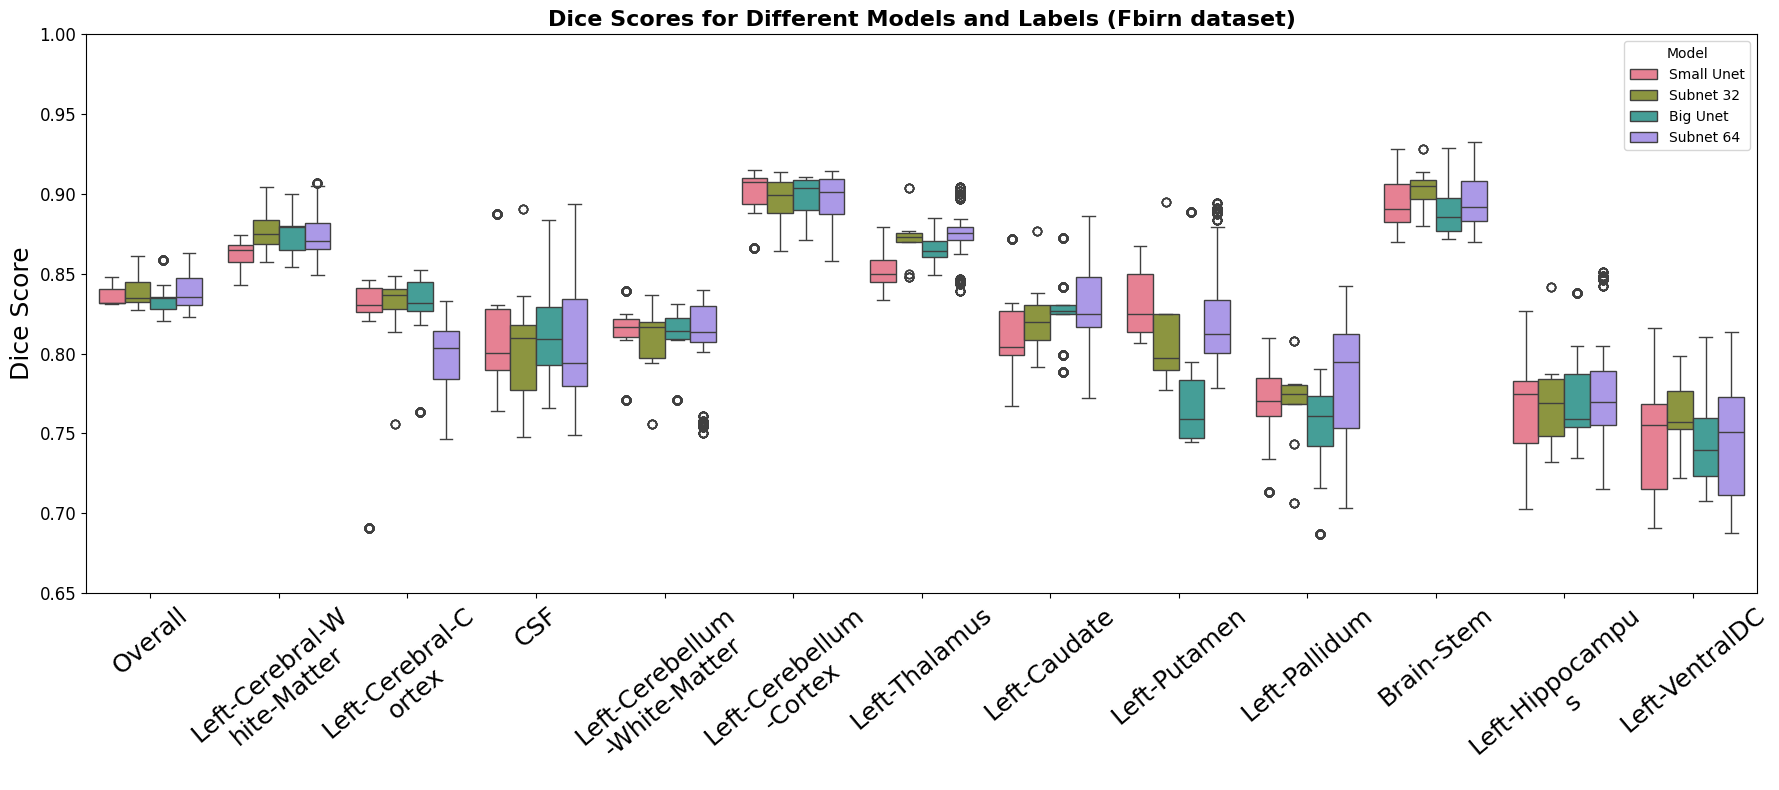

Mean and Standard Deviation of Dice Scores for Each Structure and Model:

Structure: Brain-Stem
Model: Big Unet - Mean: 0.8900, Std: 0.0171
Model: Small Unet - Mean: 0.8952, Std: 0.0168
Model: Subnet 32 - Mean: 0.9028, Std: 0.0132
Model: Subnet 64 - Mean: 0.8969, Std: 0.0180

Structure: CSF
Model: Big Unet - Mean: 0.8124, Std: 0.0323
Model: Small Unet - Mean: 0.8083, Std: 0.0345
Model: Subnet 32 - Mean: 0.8064, Std: 0.0391
Model: Subnet 64 - Mean: 0.8076, Std: 0.0388

Structure: Left-Caudate
Model: Big Unet - Mean: 0.8256, Std: 0.0225
Model: Small Unet - Mean: 0.8130, Std: 0.0269
Model: Subnet 32 - Mean: 0.8218, Std: 0.0232
Model: Subnet 64 - Mean: 0.8329, Std: 0.0250

Structure: Left-Cerebellum-Cortex
Model: Big Unet - Mean: 0.8991, Std: 0.0123
Model: Small Unet - Mean: 0.9008, Std: 0.0148
Model: Subnet 32 - Mean: 0.8979, Std: 0.0144
Model: Subnet 64 - Mean: 0.8963, Std: 0.0160

Structure: Left-Cerebellum-White-Matter
Model: Big Unet - Mean: 0.8128, Std: 0.0163
Model: Small Unet - Mea

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from scipy import stats
# Define the dataset
# dataset = "buckner40"
dataset = "fbirn"
# dataset = "oasis"

label_ids = {
    "Unknown": 0,
    "Left-Cerebral-White-Matter": 1,
    "Left-Cerebral-Cortex": 2,
    "CSF": 3,
    "Left-Cerebellum-White-Matter": 4,
    "Left-Cerebellum-Cortex": 5,
    "Left-Thalamus": 6,
    "Left-Caudate": 7,
    "Left-Putamen": 8,
    "Left-Pallidum": 9,
    "Brain-Stem": 10,
    "Left-Hippocampus": 11,
    "Left-VentralDC": 15
}

measure = "dice"
results_dir = 'results/'
csv_files = glob.glob(os.path.join(results_dir, 'result_'+dataset+'*'+measure+'*.csv'))
data_frames = []

for file in csv_files:
    model_name = os.path.basename(file).replace('result_'+dataset+'_', '').replace('.csv', '').replace(measure, '').replace('_','')
    print(model_name)
    df = pd.read_csv(file)
    df['Model'] = model_name
    data_frames.append(df)

all_results = pd.concat(data_frames, ignore_index=True)

# Adjust model names for readability
model_name_mapping = {
    '1.1': 'Small Unet',
    '1.75': 'Big Unet',
    '32': 'Subnet 32',
    '64': 'Subnet 64'
}
all_results['Model'] = all_results['Model'].map(model_name_mapping)

# Transform data to long format for plotting, excluding "Unknown"
columns_to_exclude = ["Unknown"]
included_labels = [label for label in all_results.columns if label not in columns_to_exclude and label not in ['Step', 'Model']]
long_format = pd.melt(all_results, id_vars=['Step', 'Model'], value_vars=included_labels, var_name='Label', value_name='Dice Score')

# Customize labels
label_mapping = {
}
long_format['Label'] = long_format['Label'].map(label_mapping).fillna(long_format['Label'])

# Compute mean and std for each structure and model combination
mean_std_results = long_format.groupby(['Label', 'Model'])['Dice Score'].agg(['mean', 'std']).reset_index()
mean_std_results.columns = ['Structure', 'Model', 'Mean', 'Std']

# Print the results


# Function to wrap text in labels
def wrap_labels(labels, width=15):
    wrapped_labels = []
    for label in labels:
        wrapped_label = '\n'.join([label[i:i+width] for i in range(0, len(label), width)])
        wrapped_labels.append(wrapped_label)
    return wrapped_labels

# Plot results
plt.figure(figsize=(18, 8))  # Increased figure width

# Define the order of the models
model_order = ["Small Unet", "Subnet 32", "Big Unet", "Subnet 64"]

# Using seaborn color palette
sns.set_palette("husl")
boxplot = sns.boxplot(x='Label', y='Dice Score', hue='Model', data=long_format, hue_order=model_order, palette='husl')
# boxplot = sns.boxplot(x='Label', y='Dice Score', hue='Model', data=long_format, dodge=True)

# Update title and labels with larger font sizes
plt.title('Dice Scores for Different Models and Labels (' + dataset.capitalize() + ' dataset)', fontweight='bold', fontsize=16)
plt.xlabel('' if dataset == 'buckner40' else '', fontsize=18)
plt.ylabel('Dice Score', fontsize=18)

# Conditional legend inclusion and positioning
# if dataset == 'fbirn':
#     plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=22)  # Place legend outside the plot

# Wrap x-axis labels only if the dataset is 'buckner40'
# if dataset == 'buckner40':
x_labels = [label.get_text() for label in plt.gca().get_xticklabels()]
wrapped_labels = wrap_labels(x_labels, width=15)
plt.gca().set_xticklabels(wrapped_labels, rotation=40, ha='center', fontsize=18)
# else:
    # plt.gca().set_xticklabels([])  # Remove x-axis labels for other datasets

plt.yticks(fontsize=12)
plt.ylim(0.65, 1)  # Adjust the y-axis limit to be between 0.5 and 1
plt.tight_layout()

plt.savefig('figs/'+dataset+'.png', dpi=300, bbox_inches='tight')

plt.show()

print("Mean and Standard Deviation of Dice Scores for Each Structure and Model:")
for structure in mean_std_results['Structure'].unique():
    print(f"\nStructure: {structure}")
    structure_data = mean_std_results[mean_std_results['Structure'] == structure]
    for _, row in structure_data.iterrows():
        print(f"Model: {row['Model']} - Mean: {row['Mean']:.4f}, Std: {row['Std']:.4f}")

Mean and Standard Deviation of Overall Dice Scores:
      Dataset       Model      mean       std
0       FBirn  Small Unet  0.822726  0.006691
1       FBirn   Subnet 32  0.840638  0.010443
2       FBirn    Big Unet  0.838404  0.007727
3       FBirn   Subnet 64  0.839156  0.011099
4       OASIS  Small Unet  0.846290  0.007783
5       OASIS   Subnet 32  0.868324  0.008764
6       OASIS    Big Unet  0.864060  0.006924
7       OASIS   Subnet 64  0.867573  0.008349
8   Buckner40  Small Unet  0.807845  0.034607
9   Buckner40   Subnet 32  0.821326  0.047606
10  Buckner40    Big Unet  0.825827  0.036732
11  Buckner40   Subnet 64  0.828215  0.038933


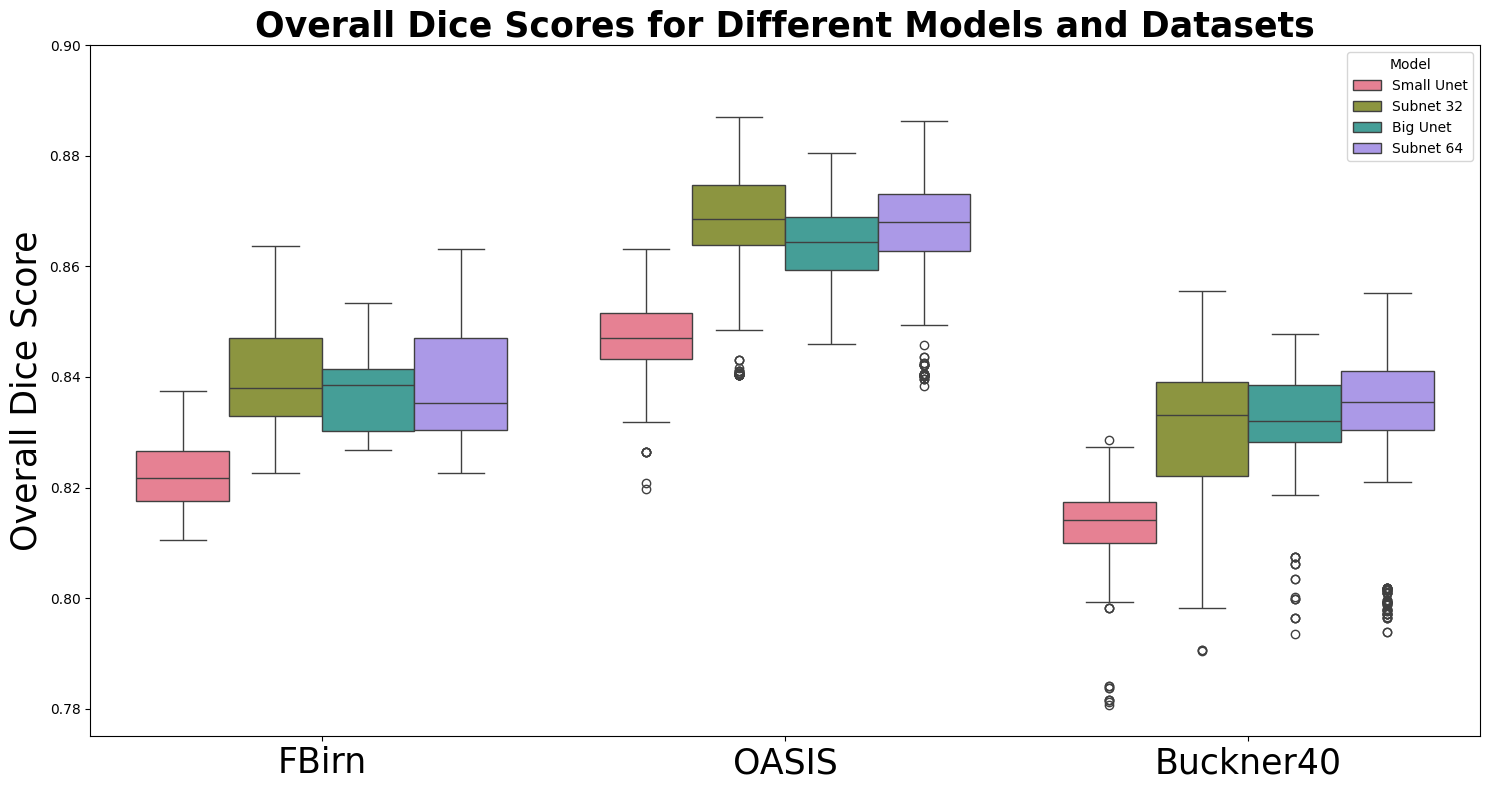

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

# Define datasets
datasets = ["buckner40", "fbirn", "oasis"]

label_ids = {
    "Unknown": 0,
    "Left-Cerebral-White-Matter": 1,
    "Left-Cerebral-Cortex": 2,
    "CSF": 3,
    "Left-Cerebellum-White-Matter": 4,
    "Left-Cerebellum-Cortex": 5,
    "Left-Thalamus": 6,
    "Left-Caudate": 7,
    "Left-Putamen": 8,
    "Left-Pallidum": 9,
    "Brain-Stem": 10,
    "Left-Hippocampus": 11,
    "Left-VentralDC": 15
}

results_dir = 'results/'
data_frames = []

# Read CSV files from all datasets and add dataset and model names
for dataset in datasets:
    csv_files = glob.glob(os.path.join(results_dir, f'result_{dataset}_*.csv'))
    for file in csv_files:
        if os.path.exists(file):
            model_name = os.path.basename(file).replace(f'result_{dataset}_', '').replace('.csv', '')
            df = pd.read_csv(file)
            df['Model'] = model_name
            df['Dataset'] = dataset
            data_frames.append(df)
        else:
            print(f"File {file} does not exist.")

# Combine all dataframes
all_results = pd.concat(data_frames, ignore_index=True)

# Adjust model names for readability
model_name_mapping = {
    '1.1': 'Small Unet',
    '1.75': 'Big Unet',
    '32': 'Subnet 32',
    '64': 'Subnet 64'
}
all_results['Model'] = all_results['Model'].map(model_name_mapping)

# Map dataset names to desired labels
dataset_mapping = {
    "fbirn": "FBirn",
    "oasis": "OASIS",
    "buckner40": "Buckner40"
}
all_results['Dataset'] = all_results['Dataset'].map(dataset_mapping)

# Filter the data for the "Overall" column
overall_results = all_results[['Dataset', 'Model', 'Overall']].dropna()

# Define the order of the models explicitly
model_order = ["Small Unet", "Subnet 32", "Big Unet", "Subnet 64"]

# Create a new column that combines Dataset and Model for better grouping in the plot
overall_results['Dataset_Model'] = overall_results['Dataset'] + " - " + overall_results['Model']

# Sort data by Dataset and Model for consistent plotting
overall_results['Dataset'] = pd.Categorical(overall_results['Dataset'], categories=["FBirn", "OASIS", "Buckner40"], ordered=True)
overall_results['Model'] = pd.Categorical(overall_results['Model'], categories=model_order, ordered=True)
overall_results = overall_results.sort_values(['Dataset', 'Model'])

# Calculate mean and std values
mean_std_values = overall_results.groupby(['Dataset', 'Model'])['Overall'].agg(['mean', 'std']).reset_index()

# Print mean and std values
print("Mean and Standard Deviation of Overall Dice Scores:")
print(mean_std_values)

# Plot overall results
plt.figure(figsize=(15, 8))

# Using seaborn color palette
sns.set_palette("husl")
boxplot = sns.boxplot(x='Dataset', y='Overall', hue='Model', data=overall_results, palette='husl')

# Update title and labels with larger font sizes
plt.title('Overall Dice Scores for Different Models and Datasets', fontweight='bold', fontsize=25)
plt.xlabel('', fontsize=14)
plt.ylabel('Overall Dice Score', fontsize=25)

# Move legend inside the plot
# plt.legend(title='Model', bbox_to_anchor=(1, 0.9), loc='upper left', fontsize=25)

# Rotate x-axis labels by 45 degrees with larger font size
plt.xticks(rotation=0, fontsize=25)

# Adjust the y-axis limit
plt.ylim(0.775, 0.9)

plt.tight_layout()
plt.savefig('figs/overall.png', dpi=300, bbox_inches='tight')

plt.show()


# Only Subnets

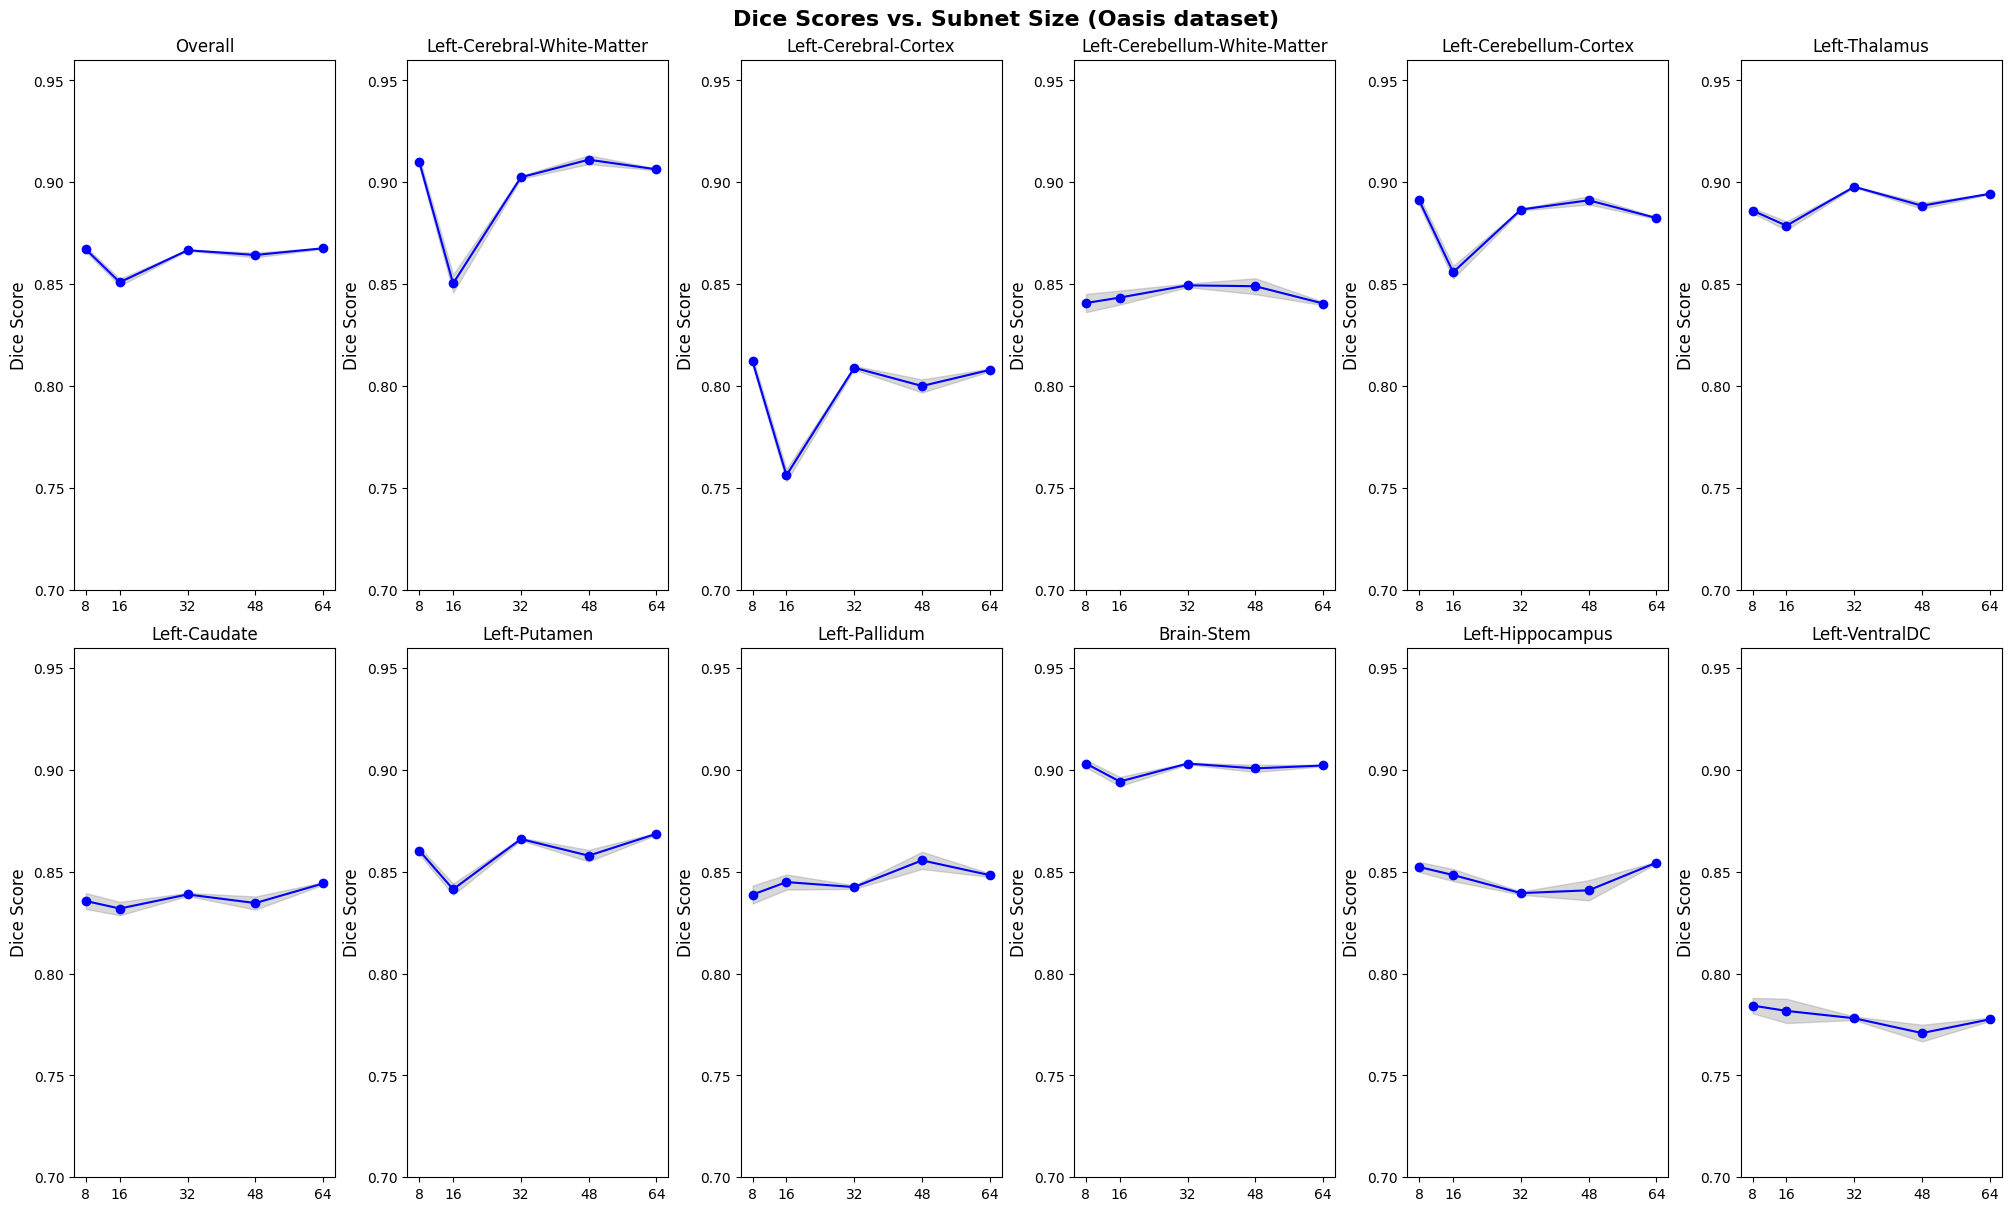

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import numpy as np

# Define the dataset
dataset = "buckner40"  # Change as needed
dataset = "fbirn"  # Change as needed
dataset = "oasis"  # Change as needed

label_ids = {
    "Unknown": 0,
    "Left-Cerebral-White-Matter": 1,
    "Left-Cerebral-Cortex": 2,
    "CSF": 3,
    "Left-Cerebellum-White-Matter": 4,
    "Left-Cerebellum-Cortex": 5,
    "Left-Thalamus": 6,
    "Left-Caudate": 7,
    "Left-Putamen": 8,
    "Left-Pallidum": 9,
    "Brain-Stem": 10,
    "Left-Hippocampus": 11,
    "Left-VentralDC": 15
}

measure = "dice"
results_dir = 'results/'
csv_files = glob.glob(os.path.join(results_dir, 'result_'+dataset+'*'+measure+'*.csv'))
data_frames = []

# Filter and load relevant CSV files
for file in csv_files:
    model_name = os.path.basename(file).replace('result_'+dataset+'_', '').replace('.csv', '').replace(measure, '').replace('_','')
    if model_name in ['8', '16', '32', '48', '64']:
        df = pd.read_csv(file)
        df['Model'] = model_name
        data_frames.append(df)

all_results = pd.concat(data_frames, ignore_index=True)

# Adjust model names for readability
model_name_mapping = {
    '8': 'Subnet 8',
    '16': 'Subnet 16',
    '32': 'Subnet 32',
    '48': 'Subnet 48',
    '64': 'Subnet 64'
}
all_results['Model'] = all_results['Model'].map(model_name_mapping)

# Transform data to long format for plotting, excluding "Unknown" and "CSF"
columns_to_exclude = ["Unknown", "CSF"]
included_labels = [label for label in all_results.columns if label not in columns_to_exclude and label not in ['Step', 'Model']]
long_format = pd.melt(all_results, id_vars=['Step', 'Model'], value_vars=included_labels, var_name='Label', value_name='Dice Score')

# Define subnet sizes and corresponding labels for the plots
subnet_sizes = [8, 16, 32, 48, 64]

# Create a 2-row, 6-column grid
fig, axes = plt.subplots(2, 6, figsize=(20, 12), constrained_layout=True)
axes = axes.flatten()  # Flatten the array of axes for easy iteration

# Create line plots for the first 6 included labels
for i, label in enumerate(included_labels[:12]):  # Limit to the first 12 labels (or fewer if available)
    ax = axes[i]
    
    # Filter data for the current label
    label_data = long_format[long_format['Label'] == label].copy()
    
    # Map subnet sizes to their corresponding numerical values for plotting
    size_mapping = {f'Subnet {size}': size for size in subnet_sizes}
    label_data['Model Size'] = label_data['Model'].map(size_mapping)
    
    # Calculate mean and standard error for each model size
    mean_scores = label_data.groupby('Model Size')['Dice Score'].mean()
    std_scores = label_data.groupby('Model Size')['Dice Score'].std()
    se_scores = std_scores / np.sqrt(label_data.groupby('Model Size')['Dice Score'].count())
    
    # Generate x values (subnet sizes) and corresponding y values (mean scores)
    x_values = mean_scores.index
    y_values = mean_scores.values
    
    # Define lower and upper bounds for the shaded area
    lower_bound = mean_scores - se_scores
    upper_bound = mean_scores + se_scores
    
    # Plot the line connecting consecutive points
    ax.plot(x_values, y_values, color='blue', linewidth=1.5, marker='o', label='Mean Dice Score')
    
    # Fill the shaded error area
    ax.fill_between(x_values, lower_bound, upper_bound, color='gray', alpha=0.3)
    
    # Update title and labels with larger font sizes
    ax.set_title(f'{label}', fontsize=12)
    ax.set_xlabel('', fontsize=12)
    ax.set_ylabel('Dice Score', fontsize=12)
    ax.set_xticks(subnet_sizes)
    ax.set_xticklabels(subnet_sizes)
    ax.set_ylim(0.7, 0.96)

# Hide any unused subplots if there are fewer than 12 labels
for j in range(len(included_labels[:12]), len(axes)):
    fig.delaxes(axes[j])

# Set a super title
plt.suptitle(f'Dice Scores vs. Subnet Size ({dataset.capitalize()} dataset)', fontsize=16, fontweight='bold')
plt.savefig(f'figs/{dataset}_subnets_mean_with_error_shading.png', dpi=300, bbox_inches='tight')
plt.show()


# Gap

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from scipy import stats

# Define the dataset
dataset = "neurite"

label_ids = {
    "Unknown": 0,
    "Left-Cerebral-White-Matter": 1,
    "Left-Cerebral-Cortex": 2,
    "CSF": 3,
    "Left-Cerebellum-White-Matter": 4,
    "Left-Cerebellum-Cortex": 5,
    "Left-Thalamus": 6,
    "Left-Caudate": 7,
    "Left-Putamen": 8,
    "Left-Pallidum": 9,
    "Brain-Stem": 10,
    "Left-Hippocampus": 11,
    "Left-VentralDC": 15
}

measure = "dice"
results_dir = 'results/'
csv_files = glob.glob(os.path.join(results_dir, 'result_'+dataset+'*'+measure+'*.csv'))
data_frames = []

for file in csv_files:
    model_name = os.path.basename(file).replace('result_'+dataset+'_', '').replace('.csv', '').replace(measure, '').replace('_','')
    print(model_name)
    df = pd.read_csv(file)
    df['Model'] = model_name
    data_frames.append(df)

all_results = pd.concat(data_frames, ignore_index=True)

# Adjust model names for readability
model_name_mapping = {
    '0': 'Small T1',
    '1': 'Big T1',
    '1.1': 'Small Unet',
    '1.75': 'Big Unet',
    '8': 'Subnet 8',
    '16': 'Subnet 16',
    '32': 'Subnet 32',
    '48': 'Subnet 48',
    '64': 'Subnet 64'
}
all_results['Model'] = all_results['Model'].map(model_name_mapping)

# Transform data to long format for plotting, excluding "Unknown"
columns_to_exclude = ["Unknown"]
included_labels = [label for label in all_results.columns if label not in columns_to_exclude and label not in ['Step', 'Model']]
long_format = pd.melt(all_results, id_vars=['Step', 'Model'], value_vars=included_labels, var_name='Label', value_name='Dice Score')

# Customize labels (add mappings if needed)
label_mapping = {}
long_format['Label'] = long_format['Label'].map(label_mapping).fillna(long_format['Label'])

# Compute mean and std for each structure and model combination
mean_std_results = long_format.groupby(['Label', 'Model'])['Dice Score'].agg(['mean', 'std']).reset_index()
mean_std_results.columns = ['Structure', 'Model', 'Mean', 'Std']

# Function to wrap text in labels
def wrap_labels(labels, width=15):
    wrapped_labels = []
    for label in labels:
        wrapped_label = '\n'.join([label[i:i+width] for i in range(0, len(label), width)])
        wrapped_labels.append(wrapped_label)
    return wrapped_labels

# Plot results
plt.figure(figsize=(18, 8))  # Increased figure width

# Define the order of the models
model_order = ["Small T1", "Small Unet", "Big T1", "Big Unet", "Subnet 8", "Subnet 16", "Subnet 32", "Subnet 48", "Subnet 64"]

# Define a custom palette with specific colors
custom_palette = sns.color_palette(["#FF6347", "#4682B4", "#32CD32", "#8A2BE2", "#FFD700", "#FF4500", "#20B2AA"])  # Example custom colors

# Apply the custom palette
sns.set_palette(custom_palette)

# Create the boxplot with the custom palette
boxplot = sns.boxplot(x='Label', y='Dice Score', hue='Model', data=long_format, hue_order=model_order, palette=custom_palette)

# Update title and labels with larger font sizes
plt.title('Dice Scores for Different Models and Labels (' + dataset.capitalize() + ' dataset)', fontweight='bold', fontsize=16)
plt.xlabel('', fontsize=18)
plt.ylabel('Dice Score', fontsize=18)

# Wrap x-axis labels
x_labels = [label.get_text() for label in plt.gca().get_xticklabels()]
wrapped_labels = wrap_labels(x_labels, width=15)
plt.gca().set_xticklabels(wrapped_labels, rotation=40, ha='center', fontsize=18)

plt.yticks(fontsize=12)
plt.ylim(0.6, 0.95)  # Adjust the y-axis limit to be between 0.65 and 1
plt.tight_layout()

plt.savefig('figs/'+dataset+'_t1.png', dpi=300, bbox_inches='tight')

plt.show()
